 # Table of Contents
Skip directly to the question answers section:
> * [Chapter QA](#QASection)

Read by Chapters:
> * [1. Understanding the Dataset](#chapter1)
>> * [1.1 Investigate Categorical Columns](#section1.1)
>> * [1.2 Investigate Numeric Columns](#section1.2)
>> * [1.3 Visualize Data](#section1.3)
>> * [Dealing With Big Data](#chunks)
>> * [1.4 Memory Optimization](#section1.4)
>>> * [1.4.1 Numeric Memory Optimization](#section1.4.1)
>>> * [1.4.2 Categorical Memory Optimization](#section1.4.2)
>> * [1.5 Data Validation and Independent Analysis](#section1.5)
>>> * [1.5.1 Convert to datetime[ns]](#section1.5.1)
>>> * [1.5.2 Convert bool to int8](#section1.5.2)
>>> * [1.5.3 Validating Categorical Data(Independent Analysis)](#section1.5.3)
>>> * [1.5.4 Validating Numeric Data(Independent Analysis)](#section1.5.4)
>> * [1.6 Data Summarization](#section1.6)
> * [2. Data Cleaning and Imputation](#section2)
>> * [2.1 Addressing Missing Data](#section2.1)
>>> * [2.1.1 Dropping Missing Values ](#section2.1.1)
>>> * [2.1.2 Addressing Categorical NaN values](#section2.1.2p1)
>>> * [2.1.2 Addressing Categorical NaN values](#section2.1.2p2)
>> * [2.2 Converting DataFrame into Chunks](#section2.2)

In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_json('/kaggle/input/hugging-face-models/data.json')

In [3]:
df.head(10)

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
0,jonatasgrosman/wav2vec2-large-xlsr-53-english,automatic-speech-recognition,72409331,316,jonatasgrosman,Jonatas Grosman,user,False,2023-03-25 10:56:55
1,bert-base-uncased,fill-mask,56077139,1214,None,None,None,False,2023-06-30 01:42:19
2,distilbert-base-uncased-finetuned-sst-2-english,text-classification,37421074,351,None,None,None,False,2023-10-26 16:14:11
3,openai/clip-vit-large-patch14,zero-shot-image-classification,32173869,723,openai,OpenAI,org,False,2023-09-15 15:49:35
4,timm/mobilenetv3_large_100.ra_in1k,image-classification,24075216,16,timm,PyTorch Image Models,org,False,2023-04-27 22:49:21
5,gpt2,text-generation,22751274,1513,None,None,None,False,2023-06-30 02:19:43
6,roberta-base,fill-mask,12651227,246,None,None,None,False,2023-03-06 15:14:53
7,xlm-roberta-base,fill-mask,10808844,420,None,None,None,False,2023-04-07 12:46:17
8,distilbert-base-uncased,fill-mask,10356803,305,None,None,None,False,2023-08-18 14:59:41
9,stabilityai/stable-diffusion-xl-base-1.0,text-to-image,9867946,3624,stabilityai,Stability AI,org,False,2023-10-30 16:03:47


* Olders modified model?
* Latest modified model?
* Top Ranking, based on: downloads, likes
* average downloads, likes per pipeline
* Top Ranking of users and enterpises and combined

# EDA: Exploratory Data Analysis
We need to review and clean the data to:
- Derive insights
- Generate Hypotheses

## 1. Understanding the Dataset: <a class='anchor' id='chapter1'> </a>

In [4]:
df.head()

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
0,jonatasgrosman/wav2vec2-large-xlsr-53-english,automatic-speech-recognition,72409331,316,jonatasgrosman,Jonatas Grosman,user,False,2023-03-25 10:56:55
1,bert-base-uncased,fill-mask,56077139,1214,None,None,None,False,2023-06-30 01:42:19
2,distilbert-base-uncased-finetuned-sst-2-english,text-classification,37421074,351,None,None,None,False,2023-10-26 16:14:11
3,openai/clip-vit-large-patch14,zero-shot-image-classification,32173869,723,openai,OpenAI,org,False,2023-09-15 15:49:35
4,timm/mobilenetv3_large_100.ra_in1k,image-classification,24075216,16,timm,PyTorch Image Models,org,False,2023-04-27 22:49:21


In [5]:
## Check shape:
df.shape

(412507, 9)

In [6]:
## Generate summary of the data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   model_id      412507 non-null  object
 1   pipeline      220219 non-null  object
 2   downloads     412507 non-null  int64 
 3   likes         412507 non-null  int64 
 4   author_id     412440 non-null  object
 5   author_name   412437 non-null  object
 6   author_type   412437 non-null  object
 7   author_isPro  412507 non-null  bool  
 8   lastModified  412507 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 25.6+ MB


### Inference: 
It would seem that there are a lot of missing values in our data. We need to address them but lets familiarize ourselves with the data a little more.

- First, the model-id is of type object with zero null values.
- The pipeline is of type object with null values equivalent to almost half of the dataset.
- The downloads is of type int64 with zero null values.
- The likes of of type int64 with zero null values.
- The author id is of type object with a few null values.
- The author name is of type object with a few null values.
- The author_isPro is of type bool with zero null values.
- The last modified is of type object with no null values.

There are 6 categorical columns, 2 numeric columns and a single boolean column.

### What we need to do:
Address categorical columns:
- Identify how many data points we have in each category
- Change the lastModified object datatype to datetime datatype

Address numeric columns:
- Address the null values
- Find a distribution

## 1.1 Investigate Categorical Columns: <a class='anchor' id='section1.1'></a>

In [7]:
df.columns

Index(['model_id', 'pipeline', 'downloads', 'likes', 'author_id',
       'author_name', 'author_type', 'author_isPro', 'lastModified'],
      dtype='object')

In [8]:
## Check the model-id category for similar model-ids
df['model_id'].nunique

<bound method IndexOpsMixin.nunique of 0           jonatasgrosman/wav2vec2-large-xlsr-53-english
1                                       bert-base-uncased
2         distilbert-base-uncased-finetuned-sst-2-english
3                           openai/clip-vit-large-patch14
4                      timm/mobilenetv3_large_100.ra_in1k
                               ...                       
412502                               dddream/disney-pixar
412503        Santp98/SBERT-pairs-paraphrase-MiniLM-L6-v2
412504                qeternity/Nous-Hermes-13b-6bpw-exl2
412505                                Apurva3509/EECS6893
412506                    neel26d/newstuned_t5_summarizer
Name: model_id, Length: 412507, dtype: object>

In [9]:
### Inference:
'''The idea is that there should not be any duplicates in the model_id column.
Therefore, it's better to drop the duplicates from the id column if there are any.
Since there aren't any duplicates, it's fine if we don't do this line of code.
I just decided I should add it here anyway.
'''
df['model_id'].drop_duplicates()

0           jonatasgrosman/wav2vec2-large-xlsr-53-english
1                                       bert-base-uncased
2         distilbert-base-uncased-finetuned-sst-2-english
3                           openai/clip-vit-large-patch14
4                      timm/mobilenetv3_large_100.ra_in1k
                               ...                       
412502                               dddream/disney-pixar
412503        Santp98/SBERT-pairs-paraphrase-MiniLM-L6-v2
412504                qeternity/Nous-Hermes-13b-6bpw-exl2
412505                                Apurva3509/EECS6893
412506                    neel26d/newstuned_t5_summarizer
Name: model_id, Length: 412507, dtype: object

In [10]:
## Check for the number of datapoints in the pipeline categorical column
df['pipeline'].value_counts()

pipeline
text-classification               40790
text-generation                   33728
reinforcement-learning            32465
text2text-generation              20690
token-classification              13661
automatic-speech-recognition      12733
text-to-image                     12536
fill-mask                          9409
question-answering                 8422
image-classification               7210
feature-extraction                 6222
audio-to-audio                     3629
translation                        2989
sentence-similarity                2697
conversational                     2598
text-to-speech                     1687
audio-classification               1429
summarization                      1420
object-detection                   1253
unconditional-image-generation      972
multiple-choice                     752
text-to-audio                       443
video-classification                410
image-segmentation                  358
image-to-text                  

In [11]:
## There are categories in the pipeline column. Let's calculate the number of categories
len(df.pipeline.value_counts())

40

## Inference:
There are a total of 40 unique categories in our pipeline column. Let's continue.

In [12]:
## Check for the number of data points in the author id categorical column
df['author_id'].value_counts()

author_id
huggingtweets    3830
Jeevesh8         3475
tkcho            3411
sail-rvc         3182
TheBloke         2758
                 ... 
arjun123            1
ezeq                1
FlegDragon          1
Wofw                1
neel26d             1
Name: count, Length: 117514, dtype: int64

## Inference:
There are 117514 categories in our author_id column.

In [13]:
## Check for the number of data points in the name categorical column
df['author_name'].value_counts()

author_name
HuggingTweets                    3830
Jeevesh Juneja                   3475
tk cho                           3411
Shinonome AI Lab - RVC Branch    3182
Tom Jobbins                      2758
                                 ... 
Ruiming                             1
Young-Seob Jeong                    1
Ashly Thampi                        1
Ilseyar Alimova                     1
Neel Desai                          1
Name: count, Length: 105613, dtype: int64

## Inference:
There are 105613 categories in our author_name column. 

### Strange:
There is a mismatch in the length of the author_names and the author_ids.
This is something to take note of. What might be happening here? My hypotheses:
- As the number of author names is lower than the number of author ids', the same author could have multiple ids.
- As there is a mismatch, it is possible that there are null values in the author ids that is causing this phenomenon.

Now then, let's check for the second case here.

In [14]:
df['author_name'].isna().sum(), df.author_id.isna().sum()

(70, 67)

It would seem that our hypothesis holds true for three values. Let's check our first hypothesis.

In [15]:
df.groupby('author_name')['author_id'].value_counts()

author_name                      author_id             
                                 catnlp123                  1
\tNima Mehrafar                  nimamehrafar               3
\tkarolina kibbermann            kibbermann                 1
                                 TheDarkLord                1
                                 TCMLM                      1
                                                           ..
😆                                username23231              1
🤗                                DJSammy                    2
🤗 Course Team Writing Assistant  team-writing-assistant     1
🧨Diffusers                       diffusers                 42
󠀀                                caefolomy                  8
Name: count, Length: 117512, dtype: int64

## Inference
Although not aesthetically pleasing, we can take away from the above information that YES! There are authors having the same name but multiple ids, as the number is more than 1 all over

In [16]:
## Check for the number of datapoints in the author type categorical column
df['author_type'].value_counts()

author_type
user    357839
org      54598
Name: count, dtype: int64

## Inference:
There are only 2 categories in our author_type column

## 1.2 Investigate numerical columns: <a class='anchor' id='section1.2'></a>

In [17]:
df.describe()

,downloads,likes
count,4.125070e+05,412507.000000
mean,1.855880e+03,1.128771
std,1.834881e+05,30.058714
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.000000e+00,0.000000
max,7.240933e+07,9637.000000


## Inference:
It's hard to understand just numbers without visualizing them. 

However, what can be taken from here is that the highest number of downloads is 72409331 and the lowest is 0. 
Using box plots for looking at the quartiles is not intuitive in this case as above 50 percent of the models have had 0 downloads!
75% of the data has had 3 downloads!

In case of likes, almost 75% has had 0 likes while a model has received 9637 likes.
Moreover, the total number of likes is 412507 so it can be said that there are popular models out there. But most of the models have not received any likes at all.

Let's visualize the distribution.

## 1.3 Visualizing the distribution of our numeric data <a class='anchor' id='section1.3'></a>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# sns.histplot(data=df, x='downloads')
# plt.show()

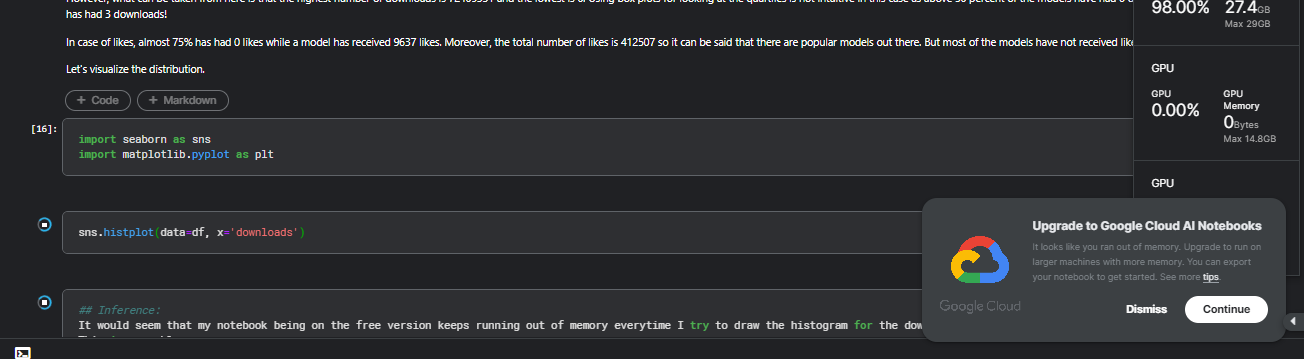

In [20]:
# sns.histplot(data=df, x='likes')
# plt.show()

## Inference: 
It would seem that my notebook being on the free version keeps running out of memory everytime I try to draw the histogram for the downloads and likes...
This is a good thing as this will enable us to deal with this problem in the earlier stage of the data analysis.

It is also a common problem when working with big data. Since our data engineers failed to reduce the data into chunks we the data scientists need to make the required adjustments here.
Let's deal with this here and now. 
We will write a python function here:

## Dealing with big data: Splitting Data into Chunks <a class='anchor' id='chunks'></a>

In [21]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [22]:
split_dataframe(df)

[                                               model_id  \
 0         jonatasgrosman/wav2vec2-large-xlsr-53-english   
 1                                     bert-base-uncased   
 2       distilbert-base-uncased-finetuned-sst-2-english   
 3                         openai/clip-vit-large-patch14   
 4                    timm/mobilenetv3_large_100.ra_in1k   
 ...                                                 ...   
 9995                                Rardilit/Panther_v1   
 9996                                         mjsp/sweet   
 9997  TheBloke/japanese-stablelm-instruct-beta-70B-GPTQ   
 9998                  apple/deeplabv3-mobilevit-x-small   
 9999                oliverguhr/wav2vec2-base-german-cv9   
 
                             pipeline  downloads  likes       author_id  \
 0       automatic-speech-recognition   72409331    316  jonatasgrosman   
 1                          fill-mask   56077139   1214            None   
 2                text-classification   37421074    3

In [23]:
chunks = split_dataframe(df=df)

In [24]:
len(chunks)

42

## Inference

Okay, so our data can be chunked... actually it has already been chunked.. but we are not going to use this yet. We will implement a few tricks on our original dataframe to optimize our memory usage first, then split them into exactly 2 or 4 chunks!

First, let's get the information on our original dataframe again.


## 1.4 Memory Optimization <a class='anchor' id='section1.4'></a>

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   model_id      412507 non-null  object
 1   pipeline      220219 non-null  object
 2   downloads     412507 non-null  int64 
 3   likes         412507 non-null  int64 
 4   author_id     412440 non-null  object
 5   author_name   412437 non-null  object
 6   author_type   412437 non-null  object
 7   author_isPro  412507 non-null  bool  
 8   lastModified  412507 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 25.6+ MB


Let's say we are only interested in the dtypes column

In [26]:
df.dtypes

model_id        object
pipeline        object
downloads        int64
likes            int64
author_id       object
author_name     object
author_type     object
author_isPro      bool
lastModified    object
dtype: object

### 1.4.1 Numeric Data Memory Optimization <a class='anchor' id='section1.4.1'></a>
Let's check our numerical data where both are int64

In [27]:
print(f"Max likes: {df['likes'].max()}, Max downloads: {df['downloads'].max()}")

Max likes: 9637, Max downloads: 72409331


In [28]:
df['likes'].memory_usage(index=False, deep=True)

3300056

## Inference
int32 would be valid for our downloads data while int16 would be better for our likes data

As we are going to perform operations that will permanently change our data, it would be in our best interests to create a copy of our data and do the operations on that copy

In [29]:
optimized_df = df.copy()
optimized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   model_id      412507 non-null  object
 1   pipeline      220219 non-null  object
 2   downloads     412507 non-null  int64 
 3   likes         412507 non-null  int64 
 4   author_id     412440 non-null  object
 5   author_name   412437 non-null  object
 6   author_type   412437 non-null  object
 7   author_isPro  412507 non-null  bool  
 8   lastModified  412507 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 25.6+ MB


In [30]:
optimized_df['likes']=optimized_df['likes'].astype('int16')
optimized_df['likes']

0          316
1         1214
2          351
3          723
4           16
          ... 
412502       0
412503       0
412504       0
412505       0
412506       0
Name: likes, Length: 412507, dtype: int16

In [31]:
optimized_df['likes'].memory_usage(index=False, deep=True)

825014

## Inference:
We have successfully reduced our memory usage of the likes series from 3300056 to 825014

In [32]:
optimized_df['downloads'].memory_usage(index=False, deep=True)

3300056

In [33]:
optimized_df['downloads'] = df['downloads'].astype('int32')
optimized_df['downloads']

0         72409331
1         56077139
2         37421074
3         32173869
4         24075216
            ...   
412502           0
412503           0
412504           0
412505           0
412506           0
Name: downloads, Length: 412507, dtype: int32

In [34]:
optimized_df['downloads'].memory_usage(index=False, deep=True)

1650028

## Inference:
We have successfully reduced our memory usage from 3300056 to 1650028

In [35]:
df2 = optimized_df.copy()

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   model_id      412507 non-null  object
 1   pipeline      220219 non-null  object
 2   downloads     412507 non-null  int32 
 3   likes         412507 non-null  int16 
 4   author_id     412440 non-null  object
 5   author_name   412437 non-null  object
 6   author_type   412437 non-null  object
 7   author_isPro  412507 non-null  bool  
 8   lastModified  412507 non-null  object
dtypes: bool(1), int16(1), int32(1), object(6)
memory usage: 21.6+ MB


Let's compare the memory usage of our second dataframe with that of our first dataframe

In [37]:
df.info(verbose=False, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Columns: 9 entries, model_id to lastModified
dtypes: bool(1), int64(2), object(6)
memory usage: 25.6+ MB


In [38]:
df2.info(verbose=False, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Columns: 9 entries, model_id to lastModified
dtypes: bool(1), int16(1), int32(1), object(6)
memory usage: 21.6+ MB


### 1.4.2 Categorical Data Memory Optimization <a class='anchor' id='section1.4.2'></a>

In [39]:
df2.dtypes

model_id        object
pipeline        object
downloads        int32
likes            int16
author_id       object
author_name     object
author_type     object
author_isPro      bool
lastModified    object
dtype: object

In [40]:
df2[['model_id','pipeline','author_id','author_name','author_type']].astype('category')

,model_id,pipeline,author_id,author_name,author_type
0,jonatasgrosman/wav2vec2-large-xlsr-53-english,automatic-speech-recognition,jonatasgrosman,Jonatas Grosman,user
1,bert-base-uncased,fill-mask,NaN,NaN,NaN
2,distilbert-base-uncased-finetuned-sst-2-english,text-classification,NaN,NaN,NaN
3,openai/clip-vit-large-patch14,zero-shot-image-classification,openai,OpenAI,org
4,timm/mobilenetv3_large_100.ra_in1k,image-classification,timm,PyTorch Image Models,org
...,...,...,...,...,...
412502,dddream/disney-pixar,NaN,dddream,star,user
412503,Santp98/SBERT-pairs-paraphrase-MiniLM-L6-v2,sentence-similarity,Santp98,santiago prado,user
412504,qeternity/Nous-Hermes-13b-6bpw-exl2,NaN,qeternity,qeternity,user
412505,Apurva3509/EECS6893,NaN,Apurva3509,Apurva Patel,user


## Inference
It seems that the None values has now turned into NaN which makes sense.

Notice how I only manipulated 5 columns and not all 6.

This is because the series for lastModified is actually supposed to be a datetime type and not a category. We will get to it soon.

However, it should be noted that it is not wise to convert all the objects into categorical data as we will see below that it raises the memory usage by 2 times! from 21.6 MB to 40.4MB

In [41]:
optimized_df2 = df2.copy()
optimized_df2[['model_id','pipeline','author_id','author_name','author_type']] = optimized_df2[['model_id','pipeline','author_id','author_name','author_type']].astype('category')

In [42]:
optimized_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model_id      412507 non-null  category
 1   pipeline      220219 non-null  category
 2   downloads     412507 non-null  int32   
 3   likes         412507 non-null  int16   
 4   author_id     412440 non-null  category
 5   author_name   412437 non-null  category
 6   author_type   412437 non-null  category
 7   author_isPro  412507 non-null  bool    
 8   lastModified  412507 non-null  object  
dtypes: bool(1), category(5), int16(1), int32(1), object(1)
memory usage: 40.4+ MB


## Inference:
So, which objects should we transform into categories?
We already looked into the number of categories in each column in the first part of our EDA.
We noticed that there are only 2 categories in our author_type column and 40 categories in our pipeline column which might seem like a lot but not really when compared to the length of our dataframe.
However, the remaining 4 columns showed categories but they were mapped one-one most of the time. It'd be wiser for us not to convert those data into categories.

In [43]:
optimized_df2 = df2.copy()
optimized_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   model_id      412507 non-null  object
 1   pipeline      220219 non-null  object
 2   downloads     412507 non-null  int32 
 3   likes         412507 non-null  int16 
 4   author_id     412440 non-null  object
 5   author_name   412437 non-null  object
 6   author_type   412437 non-null  object
 7   author_isPro  412507 non-null  bool  
 8   lastModified  412507 non-null  object
dtypes: bool(1), int16(1), int32(1), object(6)
memory usage: 21.6+ MB


In [44]:
optimized_df2['pipeline'] = optimized_df2['pipeline'].astype('category')

In [45]:
optimized_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model_id      412507 non-null  object  
 1   pipeline      220219 non-null  category
 2   downloads     412507 non-null  int32   
 3   likes         412507 non-null  int16   
 4   author_id     412440 non-null  object  
 5   author_name   412437 non-null  object  
 6   author_type   412437 non-null  object  
 7   author_isPro  412507 non-null  bool    
 8   lastModified  412507 non-null  object  
dtypes: bool(1), category(1), int16(1), int32(1), object(5)
memory usage: 18.9+ MB


In [46]:
optimized_df3 = optimized_df2.copy()
optimized_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model_id      412507 non-null  object  
 1   pipeline      220219 non-null  category
 2   downloads     412507 non-null  int32   
 3   likes         412507 non-null  int16   
 4   author_id     412440 non-null  object  
 5   author_name   412437 non-null  object  
 6   author_type   412437 non-null  object  
 7   author_isPro  412507 non-null  bool    
 8   lastModified  412507 non-null  object  
dtypes: bool(1), category(1), int16(1), int32(1), object(5)
memory usage: 18.9+ MB


In [47]:
optimized_df3['author_type'] = optimized_df3['author_type'].astype('category')
optimized_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model_id      412507 non-null  object  
 1   pipeline      220219 non-null  category
 2   downloads     412507 non-null  int32   
 3   likes         412507 non-null  int16   
 4   author_id     412440 non-null  object  
 5   author_name   412437 non-null  object  
 6   author_type   412437 non-null  category
 7   author_isPro  412507 non-null  bool    
 8   lastModified  412507 non-null  object  
dtypes: bool(1), category(2), int16(1), int32(1), object(4)
memory usage: 16.1+ MB


## Inference:
We can notice easily that our memory usage has reduced from 25.6 MB to 16.1 MB. Let's make it even clearer below.

In [48]:
df.info(verbose=False, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Columns: 9 entries, model_id to lastModified
dtypes: bool(1), int64(2), object(6)
memory usage: 25.6+ MB


In [49]:
df2.info(verbose=False, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Columns: 9 entries, model_id to lastModified
dtypes: bool(1), int16(1), int32(1), object(6)
memory usage: 21.6+ MB


In [50]:
optimized_df2.info(verbose=False, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Columns: 9 entries, model_id to lastModified
dtypes: bool(1), category(1), int16(1), int32(1), object(5)
memory usage: 18.9+ MB


In [51]:
optimized_df3.info(verbose=False, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Columns: 9 entries, model_id to lastModified
dtypes: bool(1), category(2), int16(1), int32(1), object(4)
memory usage: 16.1+ MB


In [52]:
df3 = optimized_df3.copy()

In [53]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model_id      412507 non-null  object  
 1   pipeline      220219 non-null  category
 2   downloads     412507 non-null  int32   
 3   likes         412507 non-null  int16   
 4   author_id     412440 non-null  object  
 5   author_name   412437 non-null  object  
 6   author_type   412437 non-null  category
 7   author_isPro  412507 non-null  bool    
 8   lastModified  412507 non-null  object  
dtypes: bool(1), category(2), int16(1), int32(1), object(4)
memory usage: 16.1+ MB


### Validation behind not converting author name, author id and model id as category 

As I have said that it wouldn't be intuitive to convert the object types that don't have a lot of categories in them to the category data type intuitively, it would be in my best interest to prove myself. I have done so below:

In [54]:
df['author_name'].value_counts()

author_name
HuggingTweets                    3830
Jeevesh Juneja                   3475
tk cho                           3411
Shinonome AI Lab - RVC Branch    3182
Tom Jobbins                      2758
                                 ... 
Ruiming                             1
Young-Seob Jeong                    1
Ashly Thampi                        1
Ilseyar Alimova                     1
Neel Desai                          1
Name: count, Length: 105613, dtype: int64

In [55]:
df['author_id'].value_counts()

author_id
huggingtweets    3830
Jeevesh8         3475
tkcho            3411
sail-rvc         3182
TheBloke         2758
                 ... 
arjun123            1
ezeq                1
FlegDragon          1
Wofw                1
neel26d             1
Name: count, Length: 117514, dtype: int64

In [56]:
df3['author_name'].memory_usage(), df3['author_id'].memory_usage()

(3300184, 3300184)

In [57]:
df3['author_name'].astype('category').memory_usage(), df3['author_id'].astype('category').memory_usage()

(6722172, 6817380)

In [58]:
df3['model_id'].memory_usage('category'), df3['model_id'].astype('category').memory_usage()

(3300184, 21858540)

## Inference
We have performed the following memory optimization tasks on our dataframe:
   1. We have optimized our numeric datatypes.
   2. We have optimized our categoric datatypes.
    
What we will do moving forward:
   1. We will drop columns we are not interested in.
   2. We will analyze our NaN values



What we have done so far has pertained to implementing techniques that would allow us to smartly allocate our memory. This is not all that we can do as we are yet to address the NaN values. But we can't just address the NaN values until we are confident we have familiarized ourselves with the data completely. We can also drop columns that we are not interested in, in order to optimize our memory. Since we do not have any particular goals yet, we will not drop any columns and keep the data as is.

Our next step is data validation where we will make sure that our data is accurately displayed

## 1.5 Data Validation <a class='anchor' id='section1.5'></a>

We want to make sure that our data-types are as expected before we move too far  in our data analysis.



In [59]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model_id      412507 non-null  object  
 1   pipeline      220219 non-null  category
 2   downloads     412507 non-null  int32   
 3   likes         412507 non-null  int16   
 4   author_id     412440 non-null  object  
 5   author_name   412437 non-null  object  
 6   author_type   412437 non-null  category
 7   author_isPro  412507 non-null  bool    
 8   lastModified  412507 non-null  object  
dtypes: bool(1), category(2), int16(1), int32(1), object(4)
memory usage: 16.1+ MB


In [60]:
df3.dtypes

model_id          object
pipeline        category
downloads          int32
likes              int16
author_id         object
author_name       object
author_type     category
author_isPro        bool
lastModified      object
dtype: object

The last modified should always be of dtype dataetime. Let's inspect it

### 1.5.1 Convert to datetime[ns] <a class='anchor' id='section1.5.1'></a>

In [61]:
df3.lastModified.head()

0    2023-03-25 10:56:55
1    2023-06-30 01:42:19
2    2023-10-26 16:14:11
3    2023-09-15 15:49:35
4    2023-04-27 22:49:21
Name: lastModified, dtype: object

It can be converted to dtype datetime[ns]

In [62]:
df3['lastModified'].head()

0    2023-03-25 10:56:55
1    2023-06-30 01:42:19
2    2023-10-26 16:14:11
3    2023-09-15 15:49:35
4    2023-04-27 22:49:21
Name: lastModified, dtype: object

In [63]:
df3['lastModified'].memory_usage()

3300184

In [64]:
# It is in YY-MM-DD format. It also has time in the 24 hour format, we used errors='coerce' to get rid of the date times with missing values 
df3_datetime = df3.copy()
df3_datetime['lastModified'] = pd.to_datetime(df3_datetime['lastModified'], errors='coerce')
df3_datetime['lastModified'].head()

0   2023-03-25 10:56:55
1   2023-06-30 01:42:19
2   2023-10-26 16:14:11
3   2023-09-15 15:49:35
4   2023-04-27 22:49:21
Name: lastModified, dtype: datetime64[ns]

In [65]:
# check memory usage
df3_datetime['lastModified'].memory_usage()

3300184

In [66]:
df3_datetime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412507 non-null  object        
 1   pipeline      220219 non-null  category      
 2   downloads     412507 non-null  int32         
 3   likes         412507 non-null  int16         
 4   author_id     412440 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412507 non-null  bool          
 8   lastModified  412507 non-null  datetime64[ns]
dtypes: bool(1), category(2), datetime64[ns](1), int16(1), int32(1), object(3)
memory usage: 16.1+ MB


In [67]:
df4 = df3_datetime.copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412507 non-null  object        
 1   pipeline      220219 non-null  category      
 2   downloads     412507 non-null  int32         
 3   likes         412507 non-null  int16         
 4   author_id     412440 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412507 non-null  bool          
 8   lastModified  412507 non-null  datetime64[ns]
dtypes: bool(1), category(2), datetime64[ns](1), int16(1), int32(1), object(3)
memory usage: 16.1+ MB


## Inference:
It would seem that the datetime column has not impacted our memory usage at all as it should be. 



### 1.5.2 Convert bool to int8 <a class='anchor' id='section1.5.2'></a>

Let's convert our boolean data into integers then convert it to int8 datatype which will reduce the memory usage dramatically. let's convert our boolean data into integers then convert it to int8 datatype which will reduce the memory usage dramatically.

In [68]:
df_bool_toint = df4.copy()
df_bool_toint.dtypes

model_id                object
pipeline              category
downloads                int32
likes                    int16
author_id               object
author_name             object
author_type           category
author_isPro              bool
lastModified    datetime64[ns]
dtype: object

In [69]:
df4.author_isPro.memory_usage()

412635

In [70]:
df_bool_toint['author_isPro'] = df_bool_toint['author_isPro'].astype('int8')
df_bool_toint.dtypes

model_id                object
pipeline              category
downloads                int32
likes                    int16
author_id               object
author_name             object
author_type           category
author_isPro              int8
lastModified    datetime64[ns]
dtype: object

In [71]:
df_bool_toint.author_isPro.memory_usage()

412635

In [72]:
df5 = df_bool_toint.copy()

In [73]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412507 non-null  object        
 1   pipeline      220219 non-null  category      
 2   downloads     412507 non-null  int32         
 3   likes         412507 non-null  int16         
 4   author_id     412440 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412507 non-null  int8          
 8   lastModified  412507 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


### 1.5.3 Validating Categorical Data <a class='anchor' id='section1.5.3'></a>

In [74]:
df5.dtypes

model_id                object
pipeline              category
downloads                int32
likes                    int16
author_id               object
author_name             object
author_type           category
author_isPro              int8
lastModified    datetime64[ns]
dtype: object

In [75]:
df5[['pipeline','author_type']].head()

,pipeline,author_type
0,automatic-speech-recognition,user
1,fill-mask,NaN
2,text-classification,NaN
3,zero-shot-image-classification,org
4,image-classification,org


In [76]:
## We will perform an example here, let's check our categorical column pipeline to see if our pipeline is limited to text-classification and image-classification, which it obviously isn't but just as an example
pipeline_filter=df5['pipeline'].isin(['text-classification','image-classification'])
pipeline_filter

0         False
1         False
2          True
3         False
4          True
          ...  
412502    False
412503    False
412504    False
412505    False
412506    False
Name: pipeline, Length: 412507, dtype: bool

In [77]:
## Let's filter our values for that:
filtered_df = df5[pipeline_filter]
filtered_df.head()

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
2,distilbert-base-uncased-finetuned-sst-2-english,text-classification,37421074,351,None,None,NaN,0,2023-10-26 16:14:11
4,timm/mobilenetv3_large_100.ra_in1k,image-classification,24075216,16,timm,PyTorch Image Models,org,0,2023-04-27 22:49:21
17,cardiffnlp/twitter-roberta-base-irony,text-classification,6780806,13,cardiffnlp,Cardiff NLP,org,0,2023-08-02 00:36:09
18,mrm8488/distilroberta-finetuned-financial-news...,text-classification,6521313,122,mrm8488,Manuel Romero,user,1,2023-03-16 20:03:13
19,lxyuan/distilbert-base-multilingual-cased-sent...,text-classification,6509877,53,lxyuan,Lik Xun Yuan,user,0,2023-06-24 04:09:07


## Inference:
Since, we still do not have any plan in our minds on what we wish to do with our data let's just keep it as it is




### 1.5.4 Validating numerical data <a class='anchor' id='section1.5.4'></a>

In [78]:
df.select_dtypes('number').head()

,downloads,likes
0,72409331,316
1,56077139,1214
2,37421074,351
3,32173869,723
4,24075216,16


In [79]:
df5.describe()

,downloads,likes,author_isPro,lastModified
count,4.125070e+05,412507.000000,412507.000000,412507
mean,1.855880e+03,1.128771,0.027866,2023-04-12 06:17:46.351407616
min,0.000000e+00,0.000000,0.000000,2014-08-10 19:35:46
25%,0.000000e+00,0.000000,0.000000,2023-01-19 16:18:21.500000
50%,0.000000e+00,0.000000,0.000000,2023-06-12 05:42:46
75%,3.000000e+00,0.000000,0.000000,2023-09-09 13:33:36
max,7.240933e+07,9637.000000,1.000000,2023-11-27 02:59:07
std,1.834881e+05,30.058714,0.164590,NaN


In [80]:
df5.downloads.max()

72409331

In [81]:
df5.downloads.min()

0

In [82]:
df5.likes.max()

9637

In [83]:
df5.likes.min()

0

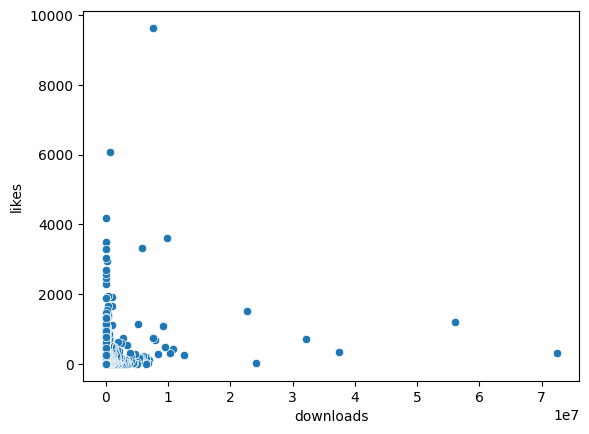

In [84]:
sns.scatterplot(data=df5, y="likes", x='downloads')
plt.show()

## Inference:

It would seem that according to the scatterplot, our likes and downloads are positively correlated for the most part.

We have also gained insight on our data's maximum and minimum values i.e. our validation range.

However, if we observe, we have two new columns when describing our data, one for the datetime and the other for the author_isPro which consists of 1s' and 0s'.

In [85]:
df6 = df5.copy()

In [86]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412507 non-null  object        
 1   pipeline      220219 non-null  category      
 2   downloads     412507 non-null  int32         
 3   likes         412507 non-null  int16         
 4   author_id     412440 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412507 non-null  int8          
 8   lastModified  412507 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


In [87]:
# sns.histplot(data=df5, x='downloads')

It would seem that our data is still too large for performing an overall distribution analysis. 
We will re-address this problem once we have addressed the NaN values.

For now let's summarize our data.

## 1.6 Data Summarization <a class='anchor' id='section1.6'></a>

We have performed both numerical and categorical validation of our data. 
Let's summarize our data. 

We will use the `.groupby()` and `.agg()` functions to perform some form of data summarization, maybe even engineer a few new features into our dataframe.

We first select the categorical column that we wish to group by then we chain an aggregating function like `.mean()`, `.median()`,`.mode()`, `.min()`, `.max()`, `.std()`, `.count()`, `.var()` and `.sum()`

We will use `.agg()` when we want to use more than one aggregating functions on the column of interest.


In [88]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412507 non-null  object        
 1   pipeline      220219 non-null  category      
 2   downloads     412507 non-null  int32         
 3   likes         412507 non-null  int16         
 4   author_id     412440 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412507 non-null  int8          
 8   lastModified  412507 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


We have two categorical data to group our data by. Let's make use of these categories first

In [89]:
df6.groupby('author_type').describe()

downloads                                               \
                count         mean  min  25%  50%  75%         max   
author_type                                                          
org           54598.0  6445.600938  0.0  0.0  2.0  7.0  32173869.0   
user         357839.0   592.762421  0.0  0.0  0.0  2.0  72409331.0   

                               likes            ... author_isPro            \
                       std     count      mean  ...          max       std   
author_type                                     ...                          
org          218776.612071   54598.0  4.396938  ...          1.0  0.054391   
user         125465.774202  357839.0  0.607002  ...          1.0  0.175092   

            lastModified                                                      \
                   count                           mean                  min   
author_type                                                                    
org                54598  2023-02-26 06:35:34.964467712  2020-04-24 15:57:20   
user              357839  2023-04-19 03:15:04.330863360  2014-08-10 19:35:46   

                                                                        \
                                       25%                         50%   
author_type                                                              
org          2022-11-22 12:14:17.249999872  2023-05-10 21:43:25.500000   
user                   2023-01-26 07:10:17         2023-06-15 04:28:00   

                                                                      
                                       75%                  max  std  
author_type                                                           
org          2023-08-25 04:09:39.750000128  2023-11-27 02:46:01  NaN  
user                   2023-09-12 15:34:55  2023-11-27 02:59:07  NaN  

[2 rows x 32 columns]

In [90]:
df6.groupby('pipeline').describe()

downloads                                   \
                                   count           mean  min   25%    50%   
pipeline                                                                    
audio-classification              1429.0    1310.452064  0.0  0.00    1.0   
audio-to-audio                    3629.0      33.280242  0.0  1.00    1.0   
automatic-speech-recognition     12733.0    7296.452918  0.0  1.00    1.0   
conversational                    2598.0     301.533102  0.0  2.00    3.0   
depth-estimation                    84.0   30716.095238  0.0  2.00    3.0   
document-question-answering        112.0    1654.169643  0.0  0.00    4.5   
feature-extraction                6222.0    2803.857281  0.0  1.00    1.0   
fill-mask                         9409.0   16116.707727  0.0  1.00    2.0   
graph-ml                            12.0    2636.666667  0.0  0.00    0.0   
image-classification              7210.0    7123.760055  0.0  1.00    1.0   
image-segmentation                 358.0    6452.494413  0.0  2.25   11.0   
image-to-image                     227.0   47509.938326  0.0  0.00   35.0   
image-to-text                      311.0   21651.366559  0.0  1.00   17.0   
multiple-choice                    752.0       3.053191  0.0  0.00    0.0   
object-detection                  1253.0    3401.528332  0.0  0.00    1.0   
other                               11.0     102.636364  0.0  1.00    5.0   
question-answering                8422.0     896.484208  0.0  2.00    3.0   
reinforcement-learning           32465.0       7.024087  0.0  0.00    1.0   
robotics                            11.0       5.090909  0.0  0.00    0.0   
sentence-similarity               2697.0    9268.222840  0.0  2.00    8.0   
summarization                     1420.0    6636.314789  0.0  2.00    4.0   
table-question-answering            79.0    1948.746835  0.0  2.00   11.0   
tabular-classification             166.0       5.373494  0.0  0.00    0.0   
tabular-regression                 102.0       1.382353  0.0  0.00    0.0   
text-classification              40790.0    2597.837534  0.0  1.00    2.0   
text-generation                  33728.0    2040.903255  0.0  4.00    5.0   
text-to-audio                      443.0     132.354402  0.0  0.00    1.0   
text-to-image                    12536.0    2803.632339  0.0  0.00    6.0   
text-to-speech                    1687.0     438.075874  0.0  0.00    0.0   
text-to-video                       71.0   17223.253521  0.0  0.00    8.0   
text2text-generation             20690.0    1093.077332  0.0  1.00    2.0   
time-series-forecasting              1.0       7.000000  7.0  7.00    7.0   
token-classification             13661.0    1543.588024  0.0  2.00    3.0   
translation                       2989.0    4112.958849  0.0  2.00    4.0   
unconditional-image-generation     972.0      61.253086  0.0  3.00   11.0   
video-classification               410.0     772.219512  0.0  0.00    1.0   
visual-question-answering           94.0    2383.691489  0.0  2.00    8.0   
voice-activity-detection            19.0  405397.736842  0.0  0.00    0.0   
zero-shot-classification           187.0   65788.283422  0.0  5.50   31.0   
zero-shot-image-classification     229.0  221504.825328  0.0  3.00  115.0   

                                                                    likes  \
                                   75%         max           std    count   
pipeline                                                                    
audio-classification              1.00   1267529.0  3.419230e+04   1429.0   
audio-to-audio                    1.00      9803.0  3.247733e+02   3629.0   
automatic-speech-recognition      1.00  72409331.0  6.447358e+05  12733.0   
conversational                    5.00    362970.0  7.530815e+03   2598.0   
depth-estimation                 11.00   2390442.0  2.609859e+05     84.0   
document-question-answering      26.00    116060.0  1.161637e+04    112.0   
feature-extraction        

## Inference:
We have successfully created a summary of our data.
However, we could dive deeper into this topic. Let's apply some aggregating functions

In [91]:
# df6.agg(['mean','std'])

The `.agg()` function will automatically apply the mean() and std() function to our numerical columns
Let's implement some aggregating functions to our downloads and likes columns.

In [92]:
# df6.agg({"downloads":["mean", "std"], "likes":["median"]})

In [93]:
# # Combining .agg() and .groupby()

# df6.groupby("pipeline").agg(
#     mean_downloads_by_pipeline = ("downloads", "mean"),
#     std_downloads_pipeline = ("downloads", "std"),
#     median_likes_by_pipeline = ("likes", "median"),
#     mode_likes_by_pipeline = ("likes", "mode")
# )

In [94]:
# df6.groupby("author_type").agg(
#     mean_downloads_by_author_type = ("downloads", "mean"),
#     std_downloads_author_type = ("downloads", "std"),
#     median_likes_by_author_type = ("likes", "median"),
#     mode_likes_by_author_type = ("likes", "mode")
# )

In [95]:
# sns.boxplot(data=df6, x='pipeline', y='likes')

## Inference:
Our data is not yet ready for summarization it would seem.
We either need to convert our data into chunks or see what happens after we cleanup the NaN values

# 2. Cleaning and Imputation <a class='anchor' id='section2'></a>

Now that we have gotten to know our data better, let's clean and impute our dataframe.

We will
- Address Missing data
- Convert and analyze categorical data
- Handle outliers

## 2.1: Addressing missing data: <a class='anchor' id='section2.1'></a>

Missing data affects distributions. Our data will be less representative of the actual population. It will make us draw incorrect conclusions.

In [96]:
df6.isna().any()

model_id        False
pipeline         True
downloads       False
likes           False
author_id        True
author_name      True
author_type      True
author_isPro    False
lastModified    False
dtype: bool

In [97]:
df6.isna().sum()

model_id             0
pipeline        192288
downloads            0
likes                0
author_id           67
author_name         70
author_type         70
author_isPro         0
lastModified         0
dtype: int64

### Inference:
As suspected, there are missing values for four of our variables.


The `pipeline` variable has a lot of missing values while the author_id has 67 and the `author_name` and `author_type` have 70

### 2.1.1 Strategies for addressing missing data: <a class='anchor' id='section2.1.1'></a>
- Drop missing values
    - 5% or less of total values
- Impute mean, median, mode
    - Depends on distribution and context (numerical variables)
- Impute by sub-groups
    - Different groups have different amounts of distribution of variables

### Dropping missing Values:

In [98]:
df7 = df6.copy()

In [99]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412507 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412507 non-null  object        
 1   pipeline      220219 non-null  category      
 2   downloads     412507 non-null  int32         
 3   likes         412507 non-null  int16         
 4   author_id     412440 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412507 non-null  int8          
 8   lastModified  412507 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


In [100]:
threshold = len(df7) * 0.05
print(threshold)

20625.350000000002


In [101]:
cols_to_drop = df7.columns[df7.isna().sum()<=threshold]
print(cols_to_drop)

Index(['model_id', 'downloads', 'likes', 'author_id', 'author_name',
       'author_type', 'author_isPro', 'lastModified'],
      dtype='object')


In [102]:
df7.dropna(subset=cols_to_drop, inplace=True)

In [103]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412437 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412437 non-null  object        
 1   pipeline      220152 non-null  category      
 2   downloads     412437 non-null  int32         
 3   likes         412437 non-null  int16         
 4   author_id     412437 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412437 non-null  int8          
 8   lastModified  412437 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 19.3+ MB


### Inference: 
We successfully dropped the missing values lower than the threshold.
Now, we filter for the remaining columns.
However, strange as it is, our memory usage skyrocketed to 19.3+ MB!!!

Is this a bug in the pandas library? No, this is because our `RangeIndex` changed to an `Int64Index` index.

Let's fix this.

In [104]:
df7 = df6.copy()
df7.dropna(subset=cols_to_drop, inplace=True)
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412437 entries, 0 to 412506
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412437 non-null  object        
 1   pipeline      220152 non-null  category      
 2   downloads     412437 non-null  int32         
 3   likes         412437 non-null  int16         
 4   author_id     412437 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412437 non-null  int8          
 8   lastModified  412437 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 19.3+ MB


In [105]:
df7 = df7.reset_index(drop=True)
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412437 entries, 0 to 412436
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412437 non-null  object        
 1   pipeline      220152 non-null  category      
 2   downloads     412437 non-null  int32         
 3   likes         412437 non-null  int16         
 4   author_id     412437 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412437 non-null  int8          
 8   lastModified  412437 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


### 2.1.2 Addressing categorical NaN values [Procedure 1] <a class='anchor' id='section2.1.2p1'></a>

We take note that we can neither drop nor impute our missing values when it comes to the pipeline variable as it is of datatype catagory. Therefore, let us predict the missing values using a classification algorithm instead.

We will do so by the following steps:
1. First create a copy of the data and drop all the rows with missing values
2. Train the model with pipeline as the target feature.
3. Use the model thus to predict the missing values from the dataframe with null values.
4. Merge the two dataframes into one.

In [106]:
!pip install scikit-learn

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [108]:
df8 = df7.copy()
df8.dropna(inplace=True)
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220152 entries, 0 to 412433
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      220152 non-null  object        
 1   pipeline      220152 non-null  category      
 2   downloads     220152 non-null  int32         
 3   likes         220152 non-null  int16         
 4   author_id     220152 non-null  object        
 5   author_name   220152 non-null  object        
 6   author_type   220152 non-null  category      
 7   author_isPro  220152 non-null  int8          
 8   lastModified  220152 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 10.3+ MB


In [109]:
df8.head()

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
0,jonatasgrosman/wav2vec2-large-xlsr-53-english,automatic-speech-recognition,72409331,316,jonatasgrosman,Jonatas Grosman,user,0,2023-03-25 10:56:55
1,openai/clip-vit-large-patch14,zero-shot-image-classification,32173869,723,openai,OpenAI,org,0,2023-09-15 15:49:35
2,timm/mobilenetv3_large_100.ra_in1k,image-classification,24075216,16,timm,PyTorch Image Models,org,0,2023-04-27 22:49:21
3,stabilityai/stable-diffusion-xl-base-1.0,text-to-image,9867946,3624,stabilityai,Stability AI,org,0,2023-10-30 16:03:47
4,sentence-transformers/all-mpnet-base-v2,sentence-similarity,9588316,487,sentence-transformers,Sentence Transformers,org,0,2023-11-02 09:35:52


### Convert objects and categories to numbers

#### Author_type:

In [110]:
df8.author_type.memory_usage()

1981492

In [111]:
df8.author_type.value_counts()

author_type
user    181583
org      38569
Name: count, dtype: int64

In [112]:
df8.author_type.isna().any()

False

In [113]:
df8.author_type = df8.author_type.replace({'user':0, 'org':1})
df8.author_type.memory_usage()

1981492

In [114]:
df8.author_type.info()

<class 'pandas.core.series.Series'>
Index: 220152 entries, 0 to 412433
Series name: author_type
Non-Null Count   Dtype   
--------------   -----   
220152 non-null  category
dtypes: category(1)
memory usage: 1.9 MB


In [115]:
df8.author_type = df8.author_type.astype('int8')
df8.author_type.memory_usage()

1981368

In [116]:
df8.author_type.info()

<class 'pandas.core.series.Series'>
Index: 220152 entries, 0 to 412433
Series name: author_type
Non-Null Count   Dtype
--------------   -----
220152 non-null  int8 
dtypes: int8(1)
memory usage: 1.9 MB


#### Drop unnecessary columns:

**Author ID**

Reason behind this is as we have already seen before, a single author could have multiple ids. It is unnecessary to make decisions based on the author id when we already have the author name

In [117]:
df8.drop('author_id', inplace=True, axis=1)
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220152 entries, 0 to 412433
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      220152 non-null  object        
 1   pipeline      220152 non-null  category      
 2   downloads     220152 non-null  int32         
 3   likes         220152 non-null  int16         
 4   author_name   220152 non-null  object        
 5   author_type   220152 non-null  int8          
 6   author_isPro  220152 non-null  int8          
 7   lastModified  220152 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), int16(1), int32(1), int8(2), object(2)
memory usage: 8.6+ MB


In [118]:
len(df8.author_name.value_counts())

43460

It would seem that there are 43,460 authors and they are important in determining the pipeline of the model.

The lastModified column isn't as important so we will drop it.

Since the model_id are all unique, intuitively it is possible to draw the conclusion that they will not contribute much to the prediction of which model belongs to which pipeline. To reduce the stress on our RAM, let's drop it as well.

In [119]:
df8.drop(['model_id','lastModified'], inplace=True, axis=1)

In [120]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220152 entries, 0 to 412433
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   pipeline      220152 non-null  category
 1   downloads     220152 non-null  int32   
 2   likes         220152 non-null  int16   
 3   author_name   220152 non-null  object  
 4   author_type   220152 non-null  int8    
 5   author_isPro  220152 non-null  int8    
dtypes: category(1), int16(1), int32(1), int8(2), object(1)
memory usage: 5.3+ MB


Let's finally convert the dtype auth_name to int dtype using pd.get_dummies

In [121]:
# df8_dummies = df8['author_name']
# df8_dummies = pd.get_dummies(df8.author_name)

In [122]:
# df8 = pd.concat([df8,df8_dummies], axis='columns')

We keep losing precious RAM memory when we try to do this. Best not try this until we have converted our data into chunks

In [123]:
df8.drop('author_name', inplace=True, axis=1)

In [124]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220152 entries, 0 to 412433
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   pipeline      220152 non-null  category
 1   downloads     220152 non-null  int32   
 2   likes         220152 non-null  int16   
 3   author_type   220152 non-null  int8    
 4   author_isPro  220152 non-null  int8    
dtypes: category(1), int16(1), int32(1), int8(2)
memory usage: 3.6 MB


In [125]:
# X = df8.drop('pipeline', axis=1).values
# y = df8['pipeline'].values

# X_train, X_test, y_train, y_test = train_test_split(X,y,
#                                                    test_size=0.2,
#                                                    random_state=0)

# forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
#                                 max_features=0.6, min_samples_leaf=3, n_jobs=-1)

# forest.fit(X_train, y_train)

# y_pred_train - forest.predict(X_train)
# y_pred = forest.predict(X_test)

# y_pred_proba = forest.predict_proba(X_test)

# accuracy_train = accuracy_score(y_train, y_pred_train)
# accuracy_test = accuracy_score(y_test, y_pred)

# print(f"Accuracy: Train={accuracy_train} Test={accuracy_test}")
# print(f"Log Loss: {log_loss(y_test,y_pred_proba)}")

### Inference:
It seems that our notebook ram will not let us perform this form of analysis either.
This is not unusual but it goes to show just how important it is to allocate memory before getting started with any form of data analytics.

Dropping all the observations with NaN values seem like a luxury now.. but let's follow procedure2 instead which would be more appropriate in our case.

#### 2.1.2 Addressing Missing Categorical Data [Procedure2] <a class='anchor' id='section2.1.2p2'></a>

The reason behind following a second procedure is that, if you put some thought into the matter, it is only natural for models that are older to not have any pipeline. Newer models also might have no pipeline. Therefore, the missing values could easily be filled using `fillna()` by `No-Pipeline` instead of `NaN` thereby solving the issue.

Before filling the missing values however, we should make sure to convert the category type back to object type. We can return it to it's category type once we haved filled the missing values

In [126]:
df9 = df7.copy()

In [127]:
df9['pipeline'] = df9['pipeline'].astype('object')

In [128]:
df9['pipeline']=df9['pipeline'].fillna('no_pipeline')

In [129]:
df9['pipeline'] = df9['pipeline'].astype('category')

We have solved our missing values problem and now can have a look at our dataframe.

In [130]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412437 entries, 0 to 412436
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412437 non-null  object        
 1   pipeline      412437 non-null  category      
 2   downloads     412437 non-null  int32         
 3   likes         412437 non-null  int16         
 4   author_id     412437 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412437 non-null  int8          
 8   lastModified  412437 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


In [131]:
df9.isna().any()

model_id        False
pipeline        False
downloads       False
likes           False
author_id       False
author_name     False
author_type     False
author_isPro    False
lastModified    False
dtype: bool

## 2.2 Converting DataFrame into Chunks <a class='anchor' id='section2.2'></a>

Finally! The step we have been waiting for. We will convert our DataFrame into chunks before moving further. This is important as we have been facing the problem of being unable to manipulate our data.

Let us define a function to convert our data frame into chunks.

In [132]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

Now, to convert the dataframe into chunks. But let's check the length of our dataframe first.

In [133]:
len(df9)

412437

Let's try dividing it into 2 chunks and see how it goes.

In [134]:
chunks = split_dataframe(df=df9, chunk_size=len(df9)//2)

In [135]:
len(chunks)

3

In [136]:
chunked_df1, chunked_df2, chunked_df3 = chunks[0], chunks[1], chunks[2]

In [137]:
len(chunked_df1), len(chunked_df2), len(chunked_df1) + len(chunked_df2)

(206218, 206218, 412436)

In [138]:
chunked_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206218 entries, 0 to 206217
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      206218 non-null  object        
 1   pipeline      206218 non-null  category      
 2   downloads     206218 non-null  int32         
 3   likes         206218 non-null  int16         
 4   author_id     206218 non-null  object        
 5   author_name   206218 non-null  object        
 6   author_type   206218 non-null  category      
 7   author_isPro  206218 non-null  int8          
 8   lastModified  206218 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 8.1+ MB


In [139]:
chunked_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206218 entries, 206218 to 412435
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      206218 non-null  object        
 1   pipeline      206218 non-null  category      
 2   downloads     206218 non-null  int32         
 3   likes         206218 non-null  int16         
 4   author_id     206218 non-null  object        
 5   author_name   206218 non-null  object        
 6   author_type   206218 non-null  category      
 7   author_isPro  206218 non-null  int8          
 8   lastModified  206218 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 8.1+ MB


As can be seen from the information displayed, our dataframe has now just over 8.1MB of memory usage. The question is whether or not we will be able to perform EDA on this dataframe. Let us try to visualize the distribution of our data along the downloads and likes.

In [140]:
# sns.histplot(data=chunked_df1, x='downloads')
# plt.show()

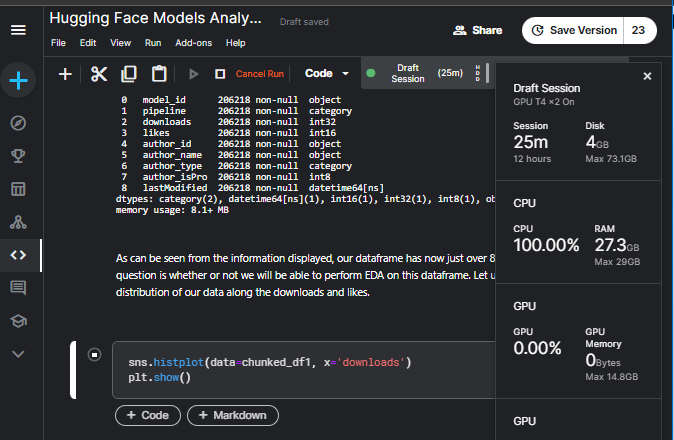

Sadly, the dataframe is still too large. Let us try to chunk it down into even smaller sets. Let's try 5 for now.

In [171]:
chunks = split_dataframe(df=df9, chunk_size=len(df9)//4)
print(f'DataFrame chunked into: {len(chunks)}')
chunk1, chunk2, chunk3, chunk4, chunk5 = chunks[0], chunks[1], chunks[2], chunks[3], chunks[4]
print(f"""Length of chunk1: {len(chunk1)}\nLength of chunk2: {len(chunk2)}\nLength of chunk3: {len(chunk3)}\nLength of chunk4: {len(chunk4)}\nLength of chunk5: {len(chunk5)}""")

DataFrame chunked into: 5
Length of chunk1: 103109
Length of chunk2: 103109
Length of chunk3: 103109
Length of chunk4: 103109
Length of chunk5: 1


In [174]:
print(chunk1.info(verbose=False, memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103109 entries, 0 to 103108
Columns: 9 entries, model_id to lastModified
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 4.0+ MB
None


In [178]:
print(f'chunk1: {chunk1.info(verbose=False, memory_usage=True)}\n')
print(f'chunk2: {chunk2.info(verbose=False, memory_usage=True)}\n')
print(f'chunk3: {chunk3.info(verbose=False, memory_usage=True)}\n')
print(f'chunk4: {chunk4.info(verbose=False, memory_usage=True)}\n')
print(f'chunk5: {chunk5.info(verbose=False, memory_usage=True)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103109 entries, 0 to 103108
Columns: 9 entries, model_id to lastModified
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 4.0+ MB
chunk1: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103109 entries, 103109 to 206217
Columns: 9 entries, model_id to lastModified
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 4.0+ MB
chunk2: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103109 entries, 206218 to 309326
Columns: 9 entries, model_id to lastModified
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 4.0+ MB
chunk3: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103109 entries, 309327 to 412435
Columns: 9 entries, model_id to lastModified
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 4.0+ MB
chunk4: None

<class 'pandas.core.frame.DataFra

In [179]:
# sns.histplot(data=chunk1, x='downloads')
# plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7b736c3d6560> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7b736c3d5870> (for post_execute):


KeyboardInterrupt: 

# Answering the questions <a class="anchor"  id="QASection"></a>

### Are we able to answer the questions yet?
- Oldest modified model?
- Latest modified model?
- Top Ranking, based on: downloads, likes
- average downloads, likes per pipeline
- Top Ranking of users and enterpises and combined

This is easy and does not need much EDA. Let's solve these one at a time

In [143]:
df_investigation = df7.copy()

In [144]:
df_investigation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412437 entries, 0 to 412436
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   model_id      412437 non-null  object        
 1   pipeline      220152 non-null  category      
 2   downloads     412437 non-null  int32         
 3   likes         412437 non-null  int16         
 4   author_id     412437 non-null  object        
 5   author_name   412437 non-null  object        
 6   author_type   412437 non-null  category      
 7   author_isPro  412437 non-null  int8          
 8   lastModified  412437 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 16.1+ MB


### Q: Oldest modified model?
A: Yuhang94/jitsimeet

In [145]:
### Oldest modified model:
df_investigation.lastModified.min()

Timestamp('2014-08-10 19:35:46')

In [146]:
df_investigation[df_investigation['lastModified'] == '2014-08-10 19:35:46']

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
278634,Yuhang94/jitsimeet,NaN,0,0,Yuhang94,zyh,user,0,2014-08-10 19:35:46


In [147]:
df_investigation[df_investigation['lastModified'] == '2014-08-10 19:35:46'].model_id

278634    Yuhang94/jitsimeet
Name: model_id, dtype: object

### Q: Lastest modified model?
A: hkivancoral/hushem_5x_deit_base_sgd_00001_fold5

In [148]:
df_investigation.lastModified.max()

Timestamp('2023-11-27 02:59:07')

In [149]:
df_investigation[df_investigation.lastModified == '2023-11-27 02:59:07']

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
412411,hkivancoral/hushem_5x_deit_base_sgd_00001_fold5,image-classification,0,0,hkivancoral,kivanc oral,user,0,2023-11-27 02:59:07


In [150]:
df_investigation[df_investigation.lastModified == '2023-11-27 02:59:07'].model_id

412411    hkivancoral/hushem_5x_deit_base_sgd_00001_fold5
Name: model_id, dtype: object

### Q: Top Ranking based on Downloads, Likes

A: This requires a few steps, but it can be done in one step. Our target is to determine the top ranked model based on downloads and likes individually and combined. To satisfy the first requirement we will determine the top by determining the maximum of both. Then create a filter and subset the dataframe according to the max values. Once done determine the `model_id`. In order to satisfy the second, we will use the `.groupby()` function.

In [151]:
df_investigation['downloads'].max(), df_investigation['likes'].max()

(72409331, 9637)

In [152]:
downloads_filter = df_investigation['downloads'] == 72409331
likes_filter = df_investigation['likes'] == 9637

In [153]:
### Top based on downloads:
df_investigation[downloads_filter]

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
0,jonatasgrosman/wav2vec2-large-xlsr-53-english,automatic-speech-recognition,72409331,316,jonatasgrosman,Jonatas Grosman,user,0,2023-03-25 10:56:55


In [154]:
df_investigation[downloads_filter].model_id

0    jonatasgrosman/wav2vec2-large-xlsr-53-english
Name: model_id, dtype: object

In [155]:
### Top based on likes:
df_investigation[likes_filter]

,model_id,pipeline,downloads,likes,author_id,author_name,author_type,author_isPro,lastModified
9,runwayml/stable-diffusion-v1-5,text-to-image,7567300,9637,runwayml,Runway,org,0,2023-08-23 21:14:19


In [156]:
df_investigation[likes_filter].model_id

9    runwayml/stable-diffusion-v1-5
Name: model_id, dtype: object

`Solution`: 
    
    Top ranked model based on downloads: jonatasgrosman/wav2vec2-large-xlsr-53-english
    Top ranked model based on likes: runwayml/stable-diffusion-v1-5

In [157]:
### Top based on both downloads and likes
top_rankers = df_investigation.groupby(by=['downloads','likes'], sort=False)['model_id'].max()
top_rankers.head()

downloads  likes
72409331   316      jonatasgrosman/wav2vec2-large-xlsr-53-english
32173869   723                      openai/clip-vit-large-patch14
24075216   16                  timm/mobilenetv3_large_100.ra_in1k
9867946    3624          stabilityai/stable-diffusion-xl-base-1.0
9588316    487            sentence-transformers/all-mpnet-base-v2
Name: model_id, dtype: object

`Solution:`

    `Top ranked based on both downloads and likes: jonatasgrosman/wav2vec2-large-xlsr-53-english`

This can be done in a roundabout fashion as I have demonstrated below:

We will add a new column called the combined score in order to solve this problem.

In [158]:
df_investigation['combined_score'] = df_investigation['downloads'] + df_investigation['likes']
df_investigation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412437 entries, 0 to 412436
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   model_id        412437 non-null  object        
 1   pipeline        220152 non-null  category      
 2   downloads       412437 non-null  int32         
 3   likes           412437 non-null  int16         
 4   author_id       412437 non-null  object        
 5   author_name     412437 non-null  object        
 6   author_type     412437 non-null  category      
 7   author_isPro    412437 non-null  int8          
 8   lastModified    412437 non-null  datetime64[ns]
 9   combined_score  412437 non-null  int32         
dtypes: category(2), datetime64[ns](1), int16(1), int32(2), int8(1), object(3)
memory usage: 17.7+ MB


In [159]:
# Find the index of the row with the highest combined score:
max_idx = df_investigation['combined_score'].idxmax()
max_idx

0

In [160]:
top_pipeline_row = df.loc[max_idx]
print("Top ranked:")
top_pipeline_row

Top ranked:


model_id        jonatasgrosman/wav2vec2-large-xlsr-53-english
pipeline                         automatic-speech-recognition
downloads                                            72409331
likes                                                     316
author_id                                      jonatasgrosman
author_name                                   Jonatas Grosman
author_type                                              user
author_isPro                                            False
lastModified                              2023-03-25 10:56:55
Name: 0, dtype: object

In [161]:
sorted_pipelines = df_investigation.sort_values(by=['downloads', 'likes'], ascending=False)
top_pipeline = sorted_pipelines.iloc[0]
print('Top-ranked Pipeline:')
print(top_pipeline)

Top-ranked Pipeline:
model_id          jonatasgrosman/wav2vec2-large-xlsr-53-english
pipeline                           automatic-speech-recognition
downloads                                              72409331
likes                                                       316
author_id                                        jonatasgrosman
author_name                                     Jonatas Grosman
author_type                                                user
author_isPro                                                  0
lastModified                                2023-03-25 10:56:55
combined_score                                         72409647
Name: 0, dtype: object


### Q: Average downloads, likes per pipeline

In [162]:
df_investigation['downloads'].mean(), df_investigation['likes'].mean()

(1367.5553648193543, 1.1087099363054236)

#### A: 
Average downloads per pipeline: 1367.5553648193543

Average likes per pipeline: 1.1087099363054236

Which is also evident from the description of the dataframe below

In [163]:
df_investigation[['downloads','likes']].describe()

,downloads,likes
count,4.124370e+05,412437.000000
mean,1.367555e+03,1.108710
std,1.414133e+05,29.849878
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.000000e+00,0.000000
max,7.240933e+07,9637.000000


### Q: Average downloads and likes per pipeline?

A: 0.002150728398149306

In [164]:
df_investigation.groupby(by=['downloads','likes'])['pipeline'].value_counts().mean()

0.002150728398149306

### Q: Top Ranking of users and enterpises and combined

In [165]:
df_investigation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412437 entries, 0 to 412436
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   model_id        412437 non-null  object        
 1   pipeline        220152 non-null  category      
 2   downloads       412437 non-null  int32         
 3   likes           412437 non-null  int16         
 4   author_id       412437 non-null  object        
 5   author_name     412437 non-null  object        
 6   author_type     412437 non-null  category      
 7   author_isPro    412437 non-null  int8          
 8   lastModified    412437 non-null  datetime64[ns]
 9   combined_score  412437 non-null  int32         
dtypes: category(2), datetime64[ns](1), int16(1), int32(2), int8(1), object(3)
memory usage: 17.7+ MB


Upon having performed EDA, we understand that users and enterprises are available as `users` and `org` under the `author_type` variable. But let's do that again for context.

In [166]:
df_investigation.author_type.value_counts()

author_type
user    357839
org      54598
Name: count, dtype: int64

As can be seen there are 357839 users and 54598 organizations. Our goal is to determine the top ranked user and organizer.

Since we were not told on what parameter we should determine our top ranked user and organizer, lets determine the users and enterprises that had the maximum amount of downloads and likes.

In [167]:
df_investigation[df_investigation['author_type']=='user']['combined_score'].idxmax()

0

In [168]:
df_investigation.loc[0]

model_id          jonatasgrosman/wav2vec2-large-xlsr-53-english
pipeline                           automatic-speech-recognition
downloads                                              72409331
likes                                                       316
author_id                                        jonatasgrosman
author_name                                     Jonatas Grosman
author_type                                                user
author_isPro                                                  0
lastModified                                2023-03-25 10:56:55
combined_score                                         72409647
Name: 0, dtype: object

`Solution`: It seems that our top scorer when it comes to the combined score of downloads and likes is the user under the name: `Jonatas Grosman`

In [169]:
df_investigation[df_investigation['author_type']=='org']['combined_score'].idxmax()

1

In [170]:
df_investigation.loc[1]

model_id           openai/clip-vit-large-patch14
pipeline          zero-shot-image-classification
downloads                               32173869
likes                                        723
author_id                                 openai
author_name                               OpenAI
author_type                                  org
author_isPro                                   0
lastModified                 2023-09-15 15:49:35
combined_score                          32174592
Name: 1, dtype: object

`Solution`: It would seem that our top scorer when it comes to the enterprise on the both the combined scores is: `OpenAI`

`Solution:` So, who came out on top individually? Obviously the user as the combined score is greater in his case.